In [1]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv(r'/content/drive/MyDrive/archive(3)/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: >

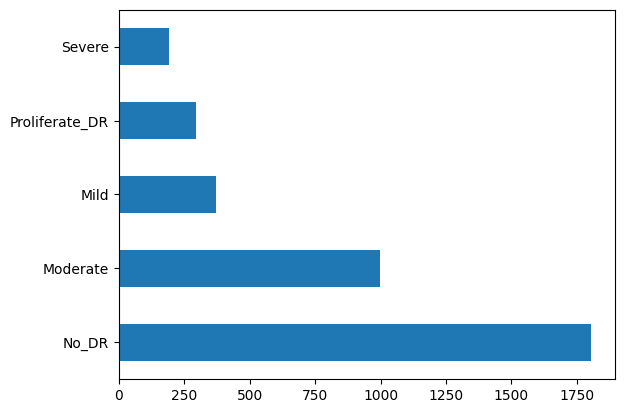

In [3]:
df['type'].value_counts().plot(kind='barh')

<Axes: >

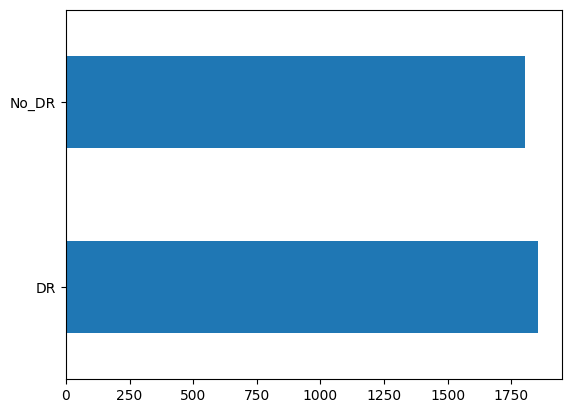

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

In [4]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [5]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [6]:
import os
import shutil

src_dir = r'/content/drive/MyDrive/archive(3)/gaussian_filtered_images/gaussian_filtered_images'
#train_dir = '/path/to/train_directory'
#val_dir = '/path/to/val_directory'
#test_dir = '/path/to/test_directory'

# Iterate over the training data
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis, id_code)  # Updated destination path
    os.makedirs(os.path.join(train_dir, binary_diagnosis), exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)

# Iterate over the validation data
for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis, id_code)  # Updated destination path
    os.makedirs(os.path.join(val_dir, binary_diagnosis), exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)

# Iterate over the test data
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis, id_code)  # Updated destination path
    os.makedirs(os.path.join(test_dir, binary_diagnosis), exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)


In [7]:
train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(train_path, target_size=(224, 224), shuffle=True)
val_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path, target_size=(224, 224), shuffle=True)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path, target_size=(224, 224),shuffle=False)

Found 2355 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [8]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/30
74/74 [==============================] - 22s 130ms/step - loss: 0.3183 - acc: 0.8964 - val_loss: 0.6748 - val_acc: 0.4644
Epoch 2/30
74/74 [==============================] - 7s 98ms/step - loss: 0.1777 - acc: 0.9389 - val_loss: 0.6247 - val_acc: 0.5455
Epoch 3/30
74/74 [==============================] - 10s 131ms/step - loss: 0.1345 - acc: 0.9482 - val_loss: 0.7400 - val_acc: 0.6087
Epoch 4/30
74/74 [==============================] - 9s 122ms/step - loss: 0.0768 - acc: 0.9656 - val_loss: 0.3914 - val_acc: 0.7945
Epoch 5/30
74/74 [==============================] - 7s 101ms/step - loss: 0.0551 - acc: 0.9686 - val_loss: 0.3245 - val_acc: 0.9328
Epoch 6/30
74/74 [==============================] - 10s 130ms/step - loss: 0.0434 - acc: 0.9779 - val_loss: 1.3433 - val_acc: 0.7727
Epoch 7/30
74/74 [==============================] - 9s 123ms/step - loss: 0.0347 - acc: 0.9800 - val_loss: 0.3651 - val_acc: 0.9190
Epoch 8/30
74/74 [==============================] - 8s 105ms/step - loss: 

In [10]:
model.save('Diabetic_Retinopathy_Detection.h5')

In [11]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

<ipython-input-11-b08fd55361be>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


16/16 [==============================] - 1s 84ms/step - loss: 0.4131 - acc: 0.9427
Loss:  0.41309621930122375
Accuracy:  0.9426877498626709


In [12]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    new_model = tf.keras.models.load_model("Diabetic_Retinopathy_Detection.h5")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')

1/1 [==============================] - 1s 710ms/step
No DR


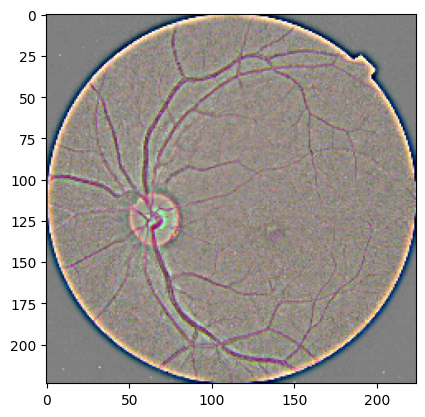

In [13]:
predict_class('/content/drive/MyDrive/archive(3)/gaussian_filtered_images/gaussian_filtered_images/No_DR/002c21358ce6.png')

1/1 [==============================] - 0s 168ms/step
DR


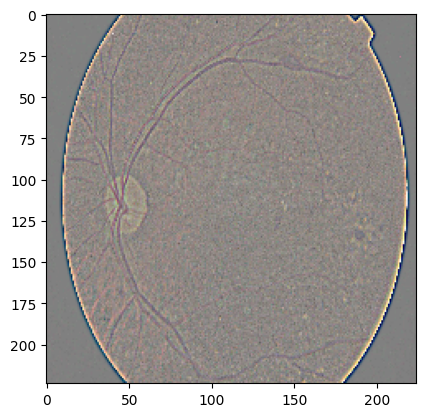

In [15]:
predict_class('/content/drive/MyDrive/archive(3)/gaussian_filtered_images/gaussian_filtered_images/Severe/03c85870824c.png')

In [ ]:
import random as rd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def plot_random_images(model_path, data_generator, num_images=80, target_size=(224, 224)):
    plt.figure(figsize=(20, 25))

    # Load the saved model
    loaded_model = load_model(model_path)

    # Assuming data_generator is your test data generator
    for i in range(80):
        random_idx = rd.randint(0, len(data_generator.filepaths) - 1)
        img_path = data_generator.filepaths[random_idx]
        img = cv2.imread(img_path)

        if img is not None and img.size > 0:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, target_size)
            img = np.expand_dims(img, axis=0) / 255.0  # Normalize to [0, 1]

            actual_class = data_generator.labels[random_idx]

            # Predict class probabilities
            class_probabilities = loaded_model.predict(img)

            # Determine the predicted class based on the highest probability
            predicted_class = "No DR" if np.argmax(class_probabilities) == 0 else "DR"

            plt.subplot(10, 8, i + 1)
            plt.imshow(img[0])
            plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}",size=9)
            plt.axis('off')
        else:
            print(f"Image at index {random_idx} could not be loaded.")

    plt.show()

# Use the function to plot random images
model_path = '/content/Diabetic_Retinopathy_Detection.h5'  # Change to your actual model path
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    'test', target_size=(224, 224), shuffle=False
)

plot_random_images(model_path, test_generator, num_images=30)


Found 506 images belonging to 2 classes.
1/1 [==============================] - 0s 19ms/step


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Load the saved model
loaded_model = load_model('64x3-CNN.model')  # Change to your actual model path

# Generate predictions for the entire validation set
val_predictions = loaded_model.predict(val_batches)

# Convert predicted probabilities to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)

# Convert actual labels to binary (0 or 1)
val_true_labels = (val_batches.classes == val_batches.class_indices['DR']).astype(int)

# Calculate precision and recall
precision = precision_score(val_true_labels, val_pred_labels)
recall = recall_score(val_true_labels, val_pred_labels)

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))


OSError: ignored

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Generate predictions for the entire validation set
val_predictions = loaded_model.predict(val_batches)

# Convert predicted probabilities to class labels
val_pred_labels = np.argmax(val_predictions, axis=1)

# Convert actual labels to binary (0 or 1)
val_true_labels = (val_batches.classes == val_batches.class_indices['DR']).astype(int)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(val_true_labels, val_pred_labels, average='binary')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1_score))
